In [1]:
### Import the required libraries
import numpy as np
import matplotlib.pyplot as plt 

import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
import tensorflow.keras as keras
tf.compat.v1.disable_eager_execution()

import os
import sys

# Append to sys.path the absolute path to src/XAIRT
path_list = os.path.abspath('').split('/')
path_src_XAIRT = ''
for link in path_list[:-1]:
    path_src_XAIRT = path_src_XAIRT+link+'/'
sys.path.append(path_src_XAIRT+'/src')

# Now import module XAIRT
from XAIRT import *

In [2]:
def basal_topology_func(x):
    b = 1.0 - 0.1*x
    return b

def solution(nx, nt, L, T, M, basal_topology_func):

    if len(M) != nx + 1:
        raise ValueError('M specified but len(M) != nx + 1')
        
    dx = L/nx
    dt = T/nt
    x = np.linspace(0,L,nx+1)
    t = np.linspace(0,T,nt+1)

    b = basal_topology_func(x)

    A = 1e-16
    rho = 920.0
    g = 9.2 
    n = 3

    C = 2*A/(n+2) * (rho*g)**n * (1e3)**n

    h = np.zeros((nx+1,nt+1))
    H = np.zeros((nx+1,nt+1))
    h[:,0] = b
    h[0,:] = b[0]
    h[-1,:] = b[-1]

    H[:,0] = h[:,0] - b
    H[0,:] = h[0,:] - b[0]
    H[-1,:] = h[-1,:] - b[-1]

    for i in range(1,len(t)):

        D = C *((H[1:,i-1]+H[:nx,i-1])/2.0)**(n+2) * ((h[1:,i-1] - h[:nx,i-1])/dx)**(n-1)

        phi = -D*(h[1:,i-1]-h[:nx,i-1])/dx

        h[1:nx,i] = h[1:nx,i-1] + M[1:nx]*dt - dt/dx * (phi[1:]-phi[:nx-1])
        h[1:nx,i] = (h[1:nx,i] < b[1:nx]) * b[1:nx] + (h[1:nx,i] >= b[1:nx]) * h[1:nx,i]
        H[:,i] = np.maximum(h[:,i] - b, 0.)

        if not np.any(H[:,i]>=0.0):
            raise Exception("Something went wrong.")
            
    Volume = np.sum(H)*dx
    
    return H[int(nx/3),-1], h[int(nx/2),-1], Volume

L = 30.
T = 10.
nx = 300
nt = 12000
samples = 1000

M_samples = 0.01*np.random.rand(samples, nx+1)
H_samples = np.zeros((samples,1), dtype = np.float64)
Volume_samples = np.zeros((samples,1), dtype = np.float64)

for sample in range(samples):
    if (sample+1) % 100 == 0:
        print(f'Sample #{sample+1}', end='\r')
    H_samples[sample], _, Volume_samples[sample] = solution(nx, nt, L, T, M_samples[sample], basal_topology_func)

In [3]:
def FD_grad(M, pert = 0.0001, normalize = True):
    grad = np.zeros(M.shape)

    H, *_ = solution(nx, nt, L, T, M, basal_topology_func)
    
    for i in range(len(M)):
        
        if (i+1) % 100 == 0:
            print(f'Index #{i+1}', end='\r')
            
        M_pos = np.copy(M)
        M_pos[i] = M_pos[i]*(1+pert)
        H_pos, *_ = solution(nx, nt, L, T, M_pos, basal_topology_func)
        grad[i] = (H_pos - H) / (2*pert)

    grad = grad / np.max(np.abs(grad))
    
    return grad

grad_0 = FD_grad(M_samples[0])

In [4]:
Layers = [{'size': nx+1, 'activation': None    , 'use_bias': None},
          {'size': 10 , 'activation': 'relu'  , 'use_bias': True},
          {'size': 1  , 'activation': 'linear', 'use_bias': False}]
Losses = [{'kind': 'mse', 'weight': 1.0}]

K = TrainFullyConnectedNN(M_samples, H_samples, 
                    Layers, Losses,
                    'adam', ['mae'], 
                    10, 1000, 0.2, 
                    'model', os.path.abspath(''))

best_model = K.quickTrain()

Train on 800 samples, validate on 200 samples
Epoch 1/1000
 10/800 [..............................] - ETA: 6s - loss: 0.0017 - mae: 0.0331

2023-08-08 18:46:33.520854: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/libs/gnu7/openmpi/netcdf/4.5.0/lib:/opt/ohpc/pub/libs/gnu7/openmpi/netcdf-fortran/4.4.4/lib:/opt/ohpc/pub/libs/gnu7/openmpi/hdf5/1.10.1/lib:/opt/ohpc/pub/mpi/openmpi-gnu7/1.10.7/lib:/opt/ohpc/pub/compiler/gcc/7.3.0/lib64:/home/shreyas/lis-2.1.3/installation/lib:/share/jdk-16.0.1/lib::
2023-08-08 18:46:33.520898: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-08 18:46:33.520928: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c2-2): /proc/driver/nvidia/version does not exist
2023-08-08 18:46:33.521713: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural N

400/800 [==============>...............] - ETA: 0s - loss: 5.9304e-04 - mae: 0.0200
Epoch 1: val_loss improved from inf to 0.00046, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 316us/sample - loss: 5.4088e-04 - mae: 0.0193 - val_loss: 4.5708e-04 - val_mae: 0.0177
Epoch 2/1000
540/800 [===================>..........] - ETA: 0s - loss: 4.7372e-04 - mae: 0.0183
Epoch 2: val_loss did not improve from 0.00046
800/800 [==============================] - 0s 115us/sample - loss: 4.8340e-04 - mae: 0.0184 - val_loss: 6.0183e-04 - val_mae: 0.0183
Epoch 3/1000
460/800 [================>.............] - ETA: 0s - loss: 4.7044e-04 - mae: 0.0180
Epoch 3: val_loss improved from 0.00046 to 0.00044, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 153us/sample - loss: 4.7109e-04 - mae: 0.0181 - val_loss: 4.3874e-04 - val_mae: 0.0170
Epoch 4/1000
500/800 [=================>............] - ETA: 0s - lo

Epoch 26/1000
500/800 [=================>............] - ETA: 0s - loss: 6.6095e-05 - mae: 0.0065
Epoch 26: val_loss improved from 0.00016 to 0.00015, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 144us/sample - loss: 6.5237e-05 - mae: 0.0065 - val_loss: 1.4818e-04 - val_mae: 0.0096
Epoch 27/1000
510/800 [==================>...........] - ETA: 0s - loss: 6.1933e-05 - mae: 0.0062
Epoch 27: val_loss improved from 0.00015 to 0.00014, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 143us/sample - loss: 6.4456e-05 - mae: 0.0064 - val_loss: 1.4165e-04 - val_mae: 0.0095
Epoch 28/1000
520/800 [==================>...........] - ETA: 0s - loss: 5.8148e-05 - mae: 0.0061
Epoch 28: val_loss improved from 0.00014 to 0.00013, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 145us/sample - loss: 5.7954e-05 - mae: 0.0061 - val_loss: 1.3405e-04 - va

800/800 [==============================] - 0s 120us/sample - loss: 2.2542e-05 - mae: 0.0038 - val_loss: 6.0144e-05 - val_mae: 0.0063
Epoch 52/1000
610/800 [=====================>........] - ETA: 0s - loss: 2.4960e-05 - mae: 0.0040
Epoch 52: val_loss improved from 0.00006 to 0.00006, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 121us/sample - loss: 2.3998e-05 - mae: 0.0039 - val_loss: 5.6561e-05 - val_mae: 0.0061
Epoch 53/1000
620/800 [======================>.......] - ETA: 0s - loss: 2.0249e-05 - mae: 0.0036
Epoch 53: val_loss improved from 0.00006 to 0.00006, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 120us/sample - loss: 2.0852e-05 - mae: 0.0036 - val_loss: 5.5355e-05 - val_mae: 0.0060
Epoch 54/1000
590/800 [=====================>........] - ETA: 0s - loss: 1.9024e-05 - mae: 0.0035
Epoch 54: val_loss did not improve from 0.00006
800/800 [==============================] - 0s

800/800 [==============================] - 0s 120us/sample - loss: 1.9761e-05 - mae: 0.0036 - val_loss: 4.4750e-05 - val_mae: 0.0054
Epoch 79/1000
500/800 [=================>............] - ETA: 0s - loss: 2.1736e-05 - mae: 0.0037
Epoch 79: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 122us/sample - loss: 2.1240e-05 - mae: 0.0036 - val_loss: 4.8816e-05 - val_mae: 0.0057
Epoch 80/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.7687e-05 - mae: 0.0033
Epoch 80: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 132us/sample - loss: 1.8818e-05 - mae: 0.0035 - val_loss: 4.5908e-05 - val_mae: 0.0055
Epoch 81/1000
520/800 [==================>...........] - ETA: 0s - loss: 1.8730e-05 - mae: 0.0035
Epoch 81: val_loss improved from 0.00004 to 0.00004, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 141us/sample - loss: 1.9793e-05 - mae: 0.0036 - val_loss: 

Epoch 106/1000
500/800 [=================>............] - ETA: 0s - loss: 1.6282e-05 - mae: 0.0033
Epoch 106: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 126us/sample - loss: 2.0125e-05 - mae: 0.0036 - val_loss: 5.1272e-05 - val_mae: 0.0058
Epoch 107/1000
500/800 [=================>............] - ETA: 0s - loss: 1.9106e-05 - mae: 0.0035
Epoch 107: val_loss improved from 0.00004 to 0.00004, saving model to /home/shreyas/XAIRT/examples/model.h5
800/800 [==============================] - 0s 148us/sample - loss: 1.7840e-05 - mae: 0.0034 - val_loss: 4.1551e-05 - val_mae: 0.0052
Epoch 108/1000
490/800 [=================>............] - ETA: 0s - loss: 1.6124e-05 - mae: 0.0032
Epoch 108: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 122us/sample - loss: 1.7842e-05 - mae: 0.0033 - val_loss: 6.7160e-05 - val_mae: 0.0067
Epoch 109/1000
520/800 [==================>...........] - ETA: 0s - loss: 2.1810e-05 - mae: 0.0038

800/800 [==============================] - 0s 128us/sample - loss: 2.0394e-05 - mae: 0.0036 - val_loss: 4.2512e-05 - val_mae: 0.0053
Epoch 135/1000
490/800 [=================>............] - ETA: 0s - loss: 1.7128e-05 - mae: 0.0034
Epoch 135: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 129us/sample - loss: 1.9628e-05 - mae: 0.0036 - val_loss: 4.2908e-05 - val_mae: 0.0053
Epoch 136/1000
460/800 [================>.............] - ETA: 0s - loss: 1.7617e-05 - mae: 0.0034
Epoch 136: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 132us/sample - loss: 1.8044e-05 - mae: 0.0034 - val_loss: 4.3618e-05 - val_mae: 0.0053
Epoch 137/1000
460/800 [================>.............] - ETA: 0s - loss: 1.7553e-05 - mae: 0.0034
Epoch 137: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 131us/sample - loss: 1.8453e-05 - mae: 0.0035 - val_loss: 4.4635e-05 - val_mae: 0.0054
Epoch 138/1000
470/800 [

Epoch 164/1000
500/800 [=================>............] - ETA: 0s - loss: 1.8162e-05 - mae: 0.0034
Epoch 164: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 123us/sample - loss: 1.7337e-05 - mae: 0.0033 - val_loss: 4.1854e-05 - val_mae: 0.0052
Epoch 165/1000
500/800 [=================>............] - ETA: 0s - loss: 1.7310e-05 - mae: 0.0033
Epoch 165: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 122us/sample - loss: 1.7770e-05 - mae: 0.0034 - val_loss: 4.2092e-05 - val_mae: 0.0052
Epoch 166/1000
510/800 [==================>...........] - ETA: 0s - loss: 1.8310e-05 - mae: 0.0034
Epoch 166: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 124us/sample - loss: 1.9252e-05 - mae: 0.0035 - val_loss: 4.2212e-05 - val_mae: 0.0053
Epoch 167/1000
500/800 [=================>............] - ETA: 0s - loss: 1.8602e-05 - mae: 0.0034
Epoch 167: val_loss did not improve from 0.00004
800/800 [

510/800 [==================>...........] - ETA: 0s - loss: 1.6634e-05 - mae: 0.0033
Epoch 193: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 122us/sample - loss: 1.7862e-05 - mae: 0.0034 - val_loss: 4.4278e-05 - val_mae: 0.0054
Epoch 194/1000
530/800 [==================>...........] - ETA: 0s - loss: 1.6684e-05 - mae: 0.0033
Epoch 194: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 112us/sample - loss: 1.8479e-05 - mae: 0.0035 - val_loss: 4.2636e-05 - val_mae: 0.0053
Epoch 195/1000
610/800 [=====================>........] - ETA: 0s - loss: 1.8312e-05 - mae: 0.0034
Epoch 195: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 102us/sample - loss: 1.8959e-05 - mae: 0.0035 - val_loss: 4.2293e-05 - val_mae: 0.0052
Epoch 196/1000
620/800 [======================>.......] - ETA: 0s - loss: 2.4266e-05 - mae: 0.0039
Epoch 196: val_loss did not improve from 0.00004
800/800 [===============

510/800 [==================>...........] - ETA: 0s - loss: 2.0759e-05 - mae: 0.0037
Epoch 222: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 120us/sample - loss: 1.9537e-05 - mae: 0.0035 - val_loss: 4.2890e-05 - val_mae: 0.0053
Epoch 223/1000
510/800 [==================>...........] - ETA: 0s - loss: 1.7788e-05 - mae: 0.0034
Epoch 223: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 122us/sample - loss: 1.7622e-05 - mae: 0.0034 - val_loss: 4.2734e-05 - val_mae: 0.0053
Epoch 224/1000
500/800 [=================>............] - ETA: 0s - loss: 1.6774e-05 - mae: 0.0033
Epoch 224: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 124us/sample - loss: 1.7057e-05 - mae: 0.0033 - val_loss: 4.2769e-05 - val_mae: 0.0053
Epoch 225/1000
500/800 [=================>............] - ETA: 0s - loss: 1.7215e-05 - mae: 0.0033
Epoch 225: val_loss did not improve from 0.00004
800/800 [===============

480/800 [=================>............] - ETA: 0s - loss: 1.7586e-05 - mae: 0.0034
Epoch 251: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 129us/sample - loss: 1.8943e-05 - mae: 0.0035 - val_loss: 4.8785e-05 - val_mae: 0.0056
Epoch 252/1000
490/800 [=================>............] - ETA: 0s - loss: 1.9741e-05 - mae: 0.0036
Epoch 252: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 128us/sample - loss: 1.9663e-05 - mae: 0.0035 - val_loss: 5.2661e-05 - val_mae: 0.0059
Epoch 253/1000
480/800 [=================>............] - ETA: 0s - loss: 1.9264e-05 - mae: 0.0035
Epoch 253: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 128us/sample - loss: 1.8344e-05 - mae: 0.0034 - val_loss: 4.2249e-05 - val_mae: 0.0052
Epoch 254/1000
480/800 [=================>............] - ETA: 0s - loss: 1.5827e-05 - mae: 0.0032
Epoch 254: val_loss did not improve from 0.00004
800/800 [===============

620/800 [======================>.......] - ETA: 0s - loss: 1.6563e-05 - mae: 0.0033
Epoch 280: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 100us/sample - loss: 1.6588e-05 - mae: 0.0032 - val_loss: 4.2312e-05 - val_mae: 0.0052
Epoch 281/1000
620/800 [======================>.......] - ETA: 0s - loss: 1.6792e-05 - mae: 0.0033
Epoch 281: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 99us/sample - loss: 1.6649e-05 - mae: 0.0033 - val_loss: 4.4432e-05 - val_mae: 0.0054
Epoch 282/1000
620/800 [======================>.......] - ETA: 0s - loss: 1.6820e-05 - mae: 0.0033
Epoch 282: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 101us/sample - loss: 1.7158e-05 - mae: 0.0033 - val_loss: 4.2512e-05 - val_mae: 0.0053
Epoch 283/1000
580/800 [====================>.........] - ETA: 0s - loss: 1.8575e-05 - mae: 0.0035
Epoch 283: val_loss did not improve from 0.00004
800/800 [================

490/800 [=================>............] - ETA: 0s - loss: 1.9221e-05 - mae: 0.0035
Epoch 309: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 121us/sample - loss: 1.8123e-05 - mae: 0.0034 - val_loss: 4.2361e-05 - val_mae: 0.0053
Epoch 310/1000
560/800 [====================>.........] - ETA: 0s - loss: 1.8068e-05 - mae: 0.0034
Epoch 310: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 109us/sample - loss: 1.8508e-05 - mae: 0.0034 - val_loss: 4.2409e-05 - val_mae: 0.0053
Epoch 311/1000
570/800 [====================>.........] - ETA: 0s - loss: 1.6619e-05 - mae: 0.0033
Epoch 311: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 105us/sample - loss: 1.7297e-05 - mae: 0.0033 - val_loss: 5.1428e-05 - val_mae: 0.0058
Epoch 312/1000
600/800 [=====================>........] - ETA: 0s - loss: 2.0213e-05 - mae: 0.0036
Epoch 312: val_loss did not improve from 0.00004
800/800 [===============

470/800 [================>.............] - ETA: 0s - loss: 1.6001e-05 - mae: 0.0032
Epoch 338: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 130us/sample - loss: 1.6575e-05 - mae: 0.0033 - val_loss: 4.1834e-05 - val_mae: 0.0052
Epoch 339/1000
470/800 [================>.............] - ETA: 0s - loss: 1.6050e-05 - mae: 0.0032
Epoch 339: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 130us/sample - loss: 1.7255e-05 - mae: 0.0033 - val_loss: 4.2274e-05 - val_mae: 0.0053
Epoch 340/1000
460/800 [================>.............] - ETA: 0s - loss: 1.7435e-05 - mae: 0.0033
Epoch 340: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 130us/sample - loss: 1.8030e-05 - mae: 0.0033 - val_loss: 4.2275e-05 - val_mae: 0.0053
Epoch 341/1000
500/800 [=================>............] - ETA: 0s - loss: 1.9228e-05 - mae: 0.0036
Epoch 341: val_loss did not improve from 0.00004
800/800 [===============

530/800 [==================>...........] - ETA: 0s - loss: 1.7001e-05 - mae: 0.0033
Epoch 367: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 121us/sample - loss: 1.8474e-05 - mae: 0.0034 - val_loss: 4.7310e-05 - val_mae: 0.0056
Epoch 368/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.6612e-05 - mae: 0.0033
Epoch 368: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 130us/sample - loss: 1.7496e-05 - mae: 0.0034 - val_loss: 4.2310e-05 - val_mae: 0.0053
Epoch 369/1000
490/800 [=================>............] - ETA: 0s - loss: 1.6604e-05 - mae: 0.0033
Epoch 369: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 124us/sample - loss: 1.7385e-05 - mae: 0.0034 - val_loss: 4.2238e-05 - val_mae: 0.0053
Epoch 370/1000
500/800 [=================>............] - ETA: 0s - loss: 1.6748e-05 - mae: 0.0033
Epoch 370: val_loss did not improve from 0.00004
800/800 [===============

510/800 [==================>...........] - ETA: 0s - loss: 1.7394e-05 - mae: 0.0033
Epoch 396: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 121us/sample - loss: 1.6976e-05 - mae: 0.0033 - val_loss: 4.3582e-05 - val_mae: 0.0053
Epoch 397/1000
520/800 [==================>...........] - ETA: 0s - loss: 1.6548e-05 - mae: 0.0033
Epoch 397: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 118us/sample - loss: 1.7206e-05 - mae: 0.0033 - val_loss: 4.7461e-05 - val_mae: 0.0056
Epoch 398/1000
500/800 [=================>............] - ETA: 0s - loss: 1.7423e-05 - mae: 0.0034
Epoch 398: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 122us/sample - loss: 1.7853e-05 - mae: 0.0034 - val_loss: 4.2107e-05 - val_mae: 0.0052
Epoch 399/1000
510/800 [==================>...........] - ETA: 0s - loss: 1.6921e-05 - mae: 0.0033
Epoch 399: val_loss did not improve from 0.00004
800/800 [===============

510/800 [==================>...........] - ETA: 0s - loss: 1.6222e-05 - mae: 0.0032
Epoch 425: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 121us/sample - loss: 1.6202e-05 - mae: 0.0032 - val_loss: 4.2806e-05 - val_mae: 0.0053
Epoch 426/1000
500/800 [=================>............] - ETA: 0s - loss: 1.7981e-05 - mae: 0.0034
Epoch 426: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 129us/sample - loss: 1.8617e-05 - mae: 0.0035 - val_loss: 4.7320e-05 - val_mae: 0.0055
Epoch 427/1000
520/800 [==================>...........] - ETA: 0s - loss: 1.9503e-05 - mae: 0.0035
Epoch 427: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 118us/sample - loss: 1.8681e-05 - mae: 0.0034 - val_loss: 4.1868e-05 - val_mae: 0.0052
Epoch 428/1000
520/800 [==================>...........] - ETA: 0s - loss: 1.7894e-05 - mae: 0.0034
Epoch 428: val_loss did not improve from 0.00004
800/800 [===============

Epoch 454/1000
760/800 [===========================>..] - ETA: 0s - loss: 1.7423e-05 - mae: 0.0034
Epoch 454: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 156us/sample - loss: 1.7382e-05 - mae: 0.0034 - val_loss: 4.8034e-05 - val_mae: 0.0056
Epoch 455/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.9793e-05 - mae: 0.0036
Epoch 455: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 140us/sample - loss: 1.8378e-05 - mae: 0.0034 - val_loss: 4.2651e-05 - val_mae: 0.0053
Epoch 456/1000
790/800 [============================>.] - ETA: 0s - loss: 1.6692e-05 - mae: 0.0033
Epoch 456: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 160us/sample - loss: 1.6648e-05 - mae: 0.0033 - val_loss: 4.3175e-05 - val_mae: 0.0053
Epoch 457/1000
650/800 [=======================>......] - ETA: 0s - loss: 1.6631e-05 - mae: 0.0033
Epoch 457: val_loss did not improve from 0.00004
800/800 [

480/800 [=================>............] - ETA: 0s - loss: 1.6593e-05 - mae: 0.0033
Epoch 483: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 125us/sample - loss: 1.8171e-05 - mae: 0.0034 - val_loss: 4.5235e-05 - val_mae: 0.0055
Epoch 484/1000
520/800 [==================>...........] - ETA: 0s - loss: 1.9366e-05 - mae: 0.0035
Epoch 484: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 123us/sample - loss: 1.9023e-05 - mae: 0.0035 - val_loss: 4.2198e-05 - val_mae: 0.0052
Epoch 485/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.5675e-05 - mae: 0.0032
Epoch 485: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 140us/sample - loss: 1.9034e-05 - mae: 0.0035 - val_loss: 4.9184e-05 - val_mae: 0.0056
Epoch 486/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.6884e-05 - mae: 0.0033
Epoch 486: val_loss did not improve from 0.00004
800/800 [===============

420/800 [==============>...............] - ETA: 0s - loss: 1.7276e-05 - mae: 0.0034
Epoch 512: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 139us/sample - loss: 1.7685e-05 - mae: 0.0034 - val_loss: 5.1990e-05 - val_mae: 0.0058
Epoch 513/1000
480/800 [=================>............] - ETA: 0s - loss: 1.6968e-05 - mae: 0.0033
Epoch 513: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 128us/sample - loss: 1.6875e-05 - mae: 0.0033 - val_loss: 4.3151e-05 - val_mae: 0.0053
Epoch 514/1000
480/800 [=================>............] - ETA: 0s - loss: 1.7177e-05 - mae: 0.0033
Epoch 514: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 135us/sample - loss: 1.8312e-05 - mae: 0.0034 - val_loss: 5.3331e-05 - val_mae: 0.0059
Epoch 515/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.5124e-05 - mae: 0.0031
Epoch 515: val_loss did not improve from 0.00004
800/800 [===============

450/800 [===============>..............] - ETA: 0s - loss: 1.7577e-05 - mae: 0.0034
Epoch 541: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 132us/sample - loss: 1.6885e-05 - mae: 0.0033 - val_loss: 4.2966e-05 - val_mae: 0.0053
Epoch 542/1000
480/800 [=================>............] - ETA: 0s - loss: 1.8079e-05 - mae: 0.0034
Epoch 542: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 128us/sample - loss: 1.7812e-05 - mae: 0.0034 - val_loss: 4.1970e-05 - val_mae: 0.0052
Epoch 543/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.6493e-05 - mae: 0.0033
Epoch 543: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 137us/sample - loss: 1.7095e-05 - mae: 0.0033 - val_loss: 4.2468e-05 - val_mae: 0.0053
Epoch 544/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.7270e-05 - mae: 0.0034
Epoch 544: val_loss did not improve from 0.00004
800/800 [===============

460/800 [================>.............] - ETA: 0s - loss: 1.7038e-05 - mae: 0.0034
Epoch 570: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 131us/sample - loss: 1.6285e-05 - mae: 0.0032 - val_loss: 4.3149e-05 - val_mae: 0.0053
Epoch 571/1000
490/800 [=================>............] - ETA: 0s - loss: 1.6316e-05 - mae: 0.0032
Epoch 571: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 128us/sample - loss: 1.6588e-05 - mae: 0.0033 - val_loss: 4.1990e-05 - val_mae: 0.0052
Epoch 572/1000
480/800 [=================>............] - ETA: 0s - loss: 1.5614e-05 - mae: 0.0031
Epoch 572: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 129us/sample - loss: 1.6795e-05 - mae: 0.0033 - val_loss: 4.2288e-05 - val_mae: 0.0052
Epoch 573/1000
470/800 [================>.............] - ETA: 0s - loss: 1.5500e-05 - mae: 0.0032
Epoch 573: val_loss did not improve from 0.00004
800/800 [===============

430/800 [===============>..............] - ETA: 0s - loss: 1.8350e-05 - mae: 0.0035
Epoch 599: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 139us/sample - loss: 1.8080e-05 - mae: 0.0034 - val_loss: 4.3690e-05 - val_mae: 0.0053
Epoch 600/1000
790/800 [============================>.] - ETA: 0s - loss: 1.7149e-05 - mae: 0.0034
Epoch 600: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 151us/sample - loss: 1.7127e-05 - mae: 0.0034 - val_loss: 4.2412e-05 - val_mae: 0.0052
Epoch 601/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.8132e-05 - mae: 0.0035
Epoch 601: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 148us/sample - loss: 1.7577e-05 - mae: 0.0034 - val_loss: 4.8030e-05 - val_mae: 0.0056
Epoch 602/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.7239e-05 - mae: 0.0033
Epoch 602: val_loss did not improve from 0.00004
800/800 [===============

390/800 [=============>................] - ETA: 0s - loss: 1.6399e-05 - mae: 0.0032
Epoch 628: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 145us/sample - loss: 1.6265e-05 - mae: 0.0033 - val_loss: 4.2901e-05 - val_mae: 0.0053
Epoch 629/1000
460/800 [================>.............] - ETA: 0s - loss: 1.6380e-05 - mae: 0.0032
Epoch 629: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 128us/sample - loss: 1.6085e-05 - mae: 0.0032 - val_loss: 4.3522e-05 - val_mae: 0.0053
Epoch 630/1000
490/800 [=================>............] - ETA: 0s - loss: 1.7020e-05 - mae: 0.0033
Epoch 630: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 123us/sample - loss: 1.6754e-05 - mae: 0.0033 - val_loss: 4.2336e-05 - val_mae: 0.0053
Epoch 631/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.9826e-05 - mae: 0.0035
Epoch 631: val_loss did not improve from 0.00004
800/800 [===============

410/800 [==============>...............] - ETA: 0s - loss: 1.5420e-05 - mae: 0.0032
Epoch 657: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 138us/sample - loss: 1.5900e-05 - mae: 0.0032 - val_loss: 4.2093e-05 - val_mae: 0.0052
Epoch 658/1000
470/800 [================>.............] - ETA: 0s - loss: 1.4519e-05 - mae: 0.0031
Epoch 658: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 133us/sample - loss: 1.7370e-05 - mae: 0.0034 - val_loss: 6.0460e-05 - val_mae: 0.0063
Epoch 659/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.9590e-05 - mae: 0.0036
Epoch 659: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 140us/sample - loss: 1.9527e-05 - mae: 0.0036 - val_loss: 4.9004e-05 - val_mae: 0.0056
Epoch 660/1000
470/800 [================>.............] - ETA: 0s - loss: 1.8719e-05 - mae: 0.0035
Epoch 660: val_loss did not improve from 0.00004
800/800 [===============

450/800 [===============>..............] - ETA: 0s - loss: 1.5177e-05 - mae: 0.0031
Epoch 686: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 145us/sample - loss: 1.6707e-05 - mae: 0.0033 - val_loss: 4.2935e-05 - val_mae: 0.0053
Epoch 687/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.5619e-05 - mae: 0.0032
Epoch 687: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 138us/sample - loss: 1.6678e-05 - mae: 0.0033 - val_loss: 4.5194e-05 - val_mae: 0.0054
Epoch 688/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.6455e-05 - mae: 0.0033
Epoch 688: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 139us/sample - loss: 1.8248e-05 - mae: 0.0034 - val_loss: 4.2443e-05 - val_mae: 0.0052
Epoch 689/1000
420/800 [==============>...............] - ETA: 0s - loss: 1.5718e-05 - mae: 0.0032
Epoch 689: val_loss did not improve from 0.00004
800/800 [===============

410/800 [==============>...............] - ETA: 0s - loss: 2.0620e-05 - mae: 0.0036
Epoch 715: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 141us/sample - loss: 1.9425e-05 - mae: 0.0035 - val_loss: 4.1599e-05 - val_mae: 0.0052
Epoch 716/1000
470/800 [================>.............] - ETA: 0s - loss: 1.7072e-05 - mae: 0.0034
Epoch 716: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 130us/sample - loss: 1.7390e-05 - mae: 0.0034 - val_loss: 4.3083e-05 - val_mae: 0.0053
Epoch 717/1000
490/800 [=================>............] - ETA: 0s - loss: 1.4779e-05 - mae: 0.0031
Epoch 717: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 128us/sample - loss: 1.6311e-05 - mae: 0.0032 - val_loss: 4.1985e-05 - val_mae: 0.0052
Epoch 718/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.6350e-05 - mae: 0.0033
Epoch 718: val_loss did not improve from 0.00004
800/800 [===============

520/800 [==================>...........] - ETA: 0s - loss: 1.6797e-05 - mae: 0.0033
Epoch 744: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 116us/sample - loss: 1.7231e-05 - mae: 0.0034 - val_loss: 4.1669e-05 - val_mae: 0.0052
Epoch 745/1000
500/800 [=================>............] - ETA: 0s - loss: 1.7155e-05 - mae: 0.0033
Epoch 745: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 119us/sample - loss: 1.6847e-05 - mae: 0.0033 - val_loss: 4.4572e-05 - val_mae: 0.0054
Epoch 746/1000
460/800 [================>.............] - ETA: 0s - loss: 1.6687e-05 - mae: 0.0032
Epoch 746: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 133us/sample - loss: 1.7146e-05 - mae: 0.0033 - val_loss: 4.2348e-05 - val_mae: 0.0052
Epoch 747/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.5668e-05 - mae: 0.0032
Epoch 747: val_loss did not improve from 0.00004
800/800 [===============

470/800 [================>.............] - ETA: 0s - loss: 2.1929e-05 - mae: 0.0038
Epoch 773: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 131us/sample - loss: 2.1543e-05 - mae: 0.0037 - val_loss: 4.4978e-05 - val_mae: 0.0054
Epoch 774/1000
470/800 [================>.............] - ETA: 0s - loss: 1.5509e-05 - mae: 0.0032
Epoch 774: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 132us/sample - loss: 1.6584e-05 - mae: 0.0032 - val_loss: 4.5621e-05 - val_mae: 0.0054
Epoch 775/1000
800/800 [==============================] - ETA: 0s - loss: 1.9264e-05 - mae: 0.0035
Epoch 775: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 148us/sample - loss: 1.9264e-05 - mae: 0.0035 - val_loss: 4.4016e-05 - val_mae: 0.0053
Epoch 776/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.7468e-05 - mae: 0.0033
Epoch 776: val_loss did not improve from 0.00004
800/800 [===============

470/800 [================>.............] - ETA: 0s - loss: 1.7002e-05 - mae: 0.0033
Epoch 802: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 132us/sample - loss: 1.7781e-05 - mae: 0.0034 - val_loss: 4.3138e-05 - val_mae: 0.0053
Epoch 803/1000
460/800 [================>.............] - ETA: 0s - loss: 1.9098e-05 - mae: 0.0035
Epoch 803: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 133us/sample - loss: 1.7780e-05 - mae: 0.0034 - val_loss: 4.3473e-05 - val_mae: 0.0053
Epoch 804/1000
460/800 [================>.............] - ETA: 0s - loss: 1.4577e-05 - mae: 0.0031
Epoch 804: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 127us/sample - loss: 1.9004e-05 - mae: 0.0035 - val_loss: 4.4347e-05 - val_mae: 0.0054
Epoch 805/1000
490/800 [=================>............] - ETA: 0s - loss: 1.6164e-05 - mae: 0.0032
Epoch 805: val_loss did not improve from 0.00004
800/800 [===============

520/800 [==================>...........] - ETA: 0s - loss: 1.7156e-05 - mae: 0.0034
Epoch 831: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 112us/sample - loss: 1.7461e-05 - mae: 0.0034 - val_loss: 4.5319e-05 - val_mae: 0.0054
Epoch 832/1000
570/800 [====================>.........] - ETA: 0s - loss: 1.7275e-05 - mae: 0.0033
Epoch 832: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 107us/sample - loss: 1.6711e-05 - mae: 0.0033 - val_loss: 4.3643e-05 - val_mae: 0.0053
Epoch 833/1000
510/800 [==================>...........] - ETA: 0s - loss: 1.7788e-05 - mae: 0.0034
Epoch 833: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 126us/sample - loss: 1.6854e-05 - mae: 0.0033 - val_loss: 4.1953e-05 - val_mae: 0.0052
Epoch 834/1000
430/800 [===============>..............] - ETA: 0s - loss: 1.7389e-05 - mae: 0.0033
Epoch 834: val_loss did not improve from 0.00004
800/800 [===============

780/800 [============================>.] - ETA: 0s - loss: 1.6399e-05 - mae: 0.0033
Epoch 860: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 153us/sample - loss: 1.6286e-05 - mae: 0.0032 - val_loss: 4.2192e-05 - val_mae: 0.0052
Epoch 861/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.5950e-05 - mae: 0.0032
Epoch 861: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 138us/sample - loss: 1.6775e-05 - mae: 0.0033 - val_loss: 4.1945e-05 - val_mae: 0.0052
Epoch 862/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.5851e-05 - mae: 0.0031
Epoch 862: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 140us/sample - loss: 1.6305e-05 - mae: 0.0032 - val_loss: 4.2850e-05 - val_mae: 0.0053
Epoch 863/1000
410/800 [==============>...............] - ETA: 0s - loss: 1.6261e-05 - mae: 0.0032
Epoch 863: val_loss did not improve from 0.00004
800/800 [===============

480/800 [=================>............] - ETA: 0s - loss: 1.6931e-05 - mae: 0.0033
Epoch 889: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 127us/sample - loss: 1.7381e-05 - mae: 0.0033 - val_loss: 4.5392e-05 - val_mae: 0.0055
Epoch 890/1000
770/800 [===========================>..] - ETA: 0s - loss: 1.6478e-05 - mae: 0.0032
Epoch 890: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 156us/sample - loss: 1.6451e-05 - mae: 0.0033 - val_loss: 4.3077e-05 - val_mae: 0.0053
Epoch 891/1000
390/800 [=============>................] - ETA: 0s - loss: 1.5267e-05 - mae: 0.0031
Epoch 891: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 145us/sample - loss: 1.6311e-05 - mae: 0.0033 - val_loss: 4.1798e-05 - val_mae: 0.0052
Epoch 892/1000
470/800 [================>.............] - ETA: 0s - loss: 1.6240e-05 - mae: 0.0033
Epoch 892: val_loss did not improve from 0.00004
800/800 [===============

560/800 [====================>.........] - ETA: 0s - loss: 1.8585e-05 - mae: 0.0035
Epoch 918: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 109us/sample - loss: 1.8797e-05 - mae: 0.0035 - val_loss: 4.2149e-05 - val_mae: 0.0052
Epoch 919/1000
490/800 [=================>............] - ETA: 0s - loss: 1.7836e-05 - mae: 0.0034
Epoch 919: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 122us/sample - loss: 1.7428e-05 - mae: 0.0033 - val_loss: 4.1681e-05 - val_mae: 0.0052
Epoch 920/1000
460/800 [================>.............] - ETA: 0s - loss: 1.6225e-05 - mae: 0.0033
Epoch 920: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 131us/sample - loss: 1.6446e-05 - mae: 0.0033 - val_loss: 4.5468e-05 - val_mae: 0.0054
Epoch 921/1000
440/800 [===============>..............] - ETA: 0s - loss: 1.8554e-05 - mae: 0.0034
Epoch 921: val_loss did not improve from 0.00004
800/800 [===============

480/800 [=================>............] - ETA: 0s - loss: 1.8052e-05 - mae: 0.0034
Epoch 947: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 126us/sample - loss: 1.6803e-05 - mae: 0.0033 - val_loss: 4.1606e-05 - val_mae: 0.0052
Epoch 948/1000
460/800 [================>.............] - ETA: 0s - loss: 1.6865e-05 - mae: 0.0033
Epoch 948: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 127us/sample - loss: 1.9300e-05 - mae: 0.0035 - val_loss: 5.3542e-05 - val_mae: 0.0059
Epoch 949/1000
480/800 [=================>............] - ETA: 0s - loss: 1.9611e-05 - mae: 0.0035
Epoch 949: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 124us/sample - loss: 1.8614e-05 - mae: 0.0035 - val_loss: 5.0511e-05 - val_mae: 0.0057
Epoch 950/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.5650e-05 - mae: 0.0032
Epoch 950: val_loss did not improve from 0.00004
800/800 [===============

480/800 [=================>............] - ETA: 0s - loss: 1.8045e-05 - mae: 0.0034
Epoch 976: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 130us/sample - loss: 1.7474e-05 - mae: 0.0034 - val_loss: 4.1756e-05 - val_mae: 0.0052
Epoch 977/1000
450/800 [===============>..............] - ETA: 0s - loss: 1.6970e-05 - mae: 0.0034
Epoch 977: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 134us/sample - loss: 1.6856e-05 - mae: 0.0033 - val_loss: 4.1692e-05 - val_mae: 0.0052
Epoch 978/1000
480/800 [=================>............] - ETA: 0s - loss: 1.6648e-05 - mae: 0.0033
Epoch 978: val_loss did not improve from 0.00004
800/800 [==============================] - 0s 125us/sample - loss: 1.6685e-05 - mae: 0.0033 - val_loss: 4.1700e-05 - val_mae: 0.0052
Epoch 979/1000
490/800 [=================>............] - ETA: 0s - loss: 1.5857e-05 - mae: 0.0032
Epoch 979: val_loss did not improve from 0.00004
800/800 [===============

In [5]:
normalizeDict = {'bool_':True, 'kind': 'MaxAbs'}
kwargs = {'y_ref': 0.0}

X = XAIR(best_model, 'lrp.alpha_1_beta_0', 'classic', M_samples, normalizeDict, **kwargs)
a_a1b0, _  = X.quick_analyze()

X = XAIR(best_model, 'lrp.z', 'classic', M_samples, normalizeDict, **kwargs)
a_z, _  = X.quick_analyze()

L = TrainLR(M_samples, H_samples, y_ref = 0.0, fit_intercept = False)
regr = L.quickTrain()

XL = XLR(regr, M_samples)
a_LR, _ = XL.quick_analyze()

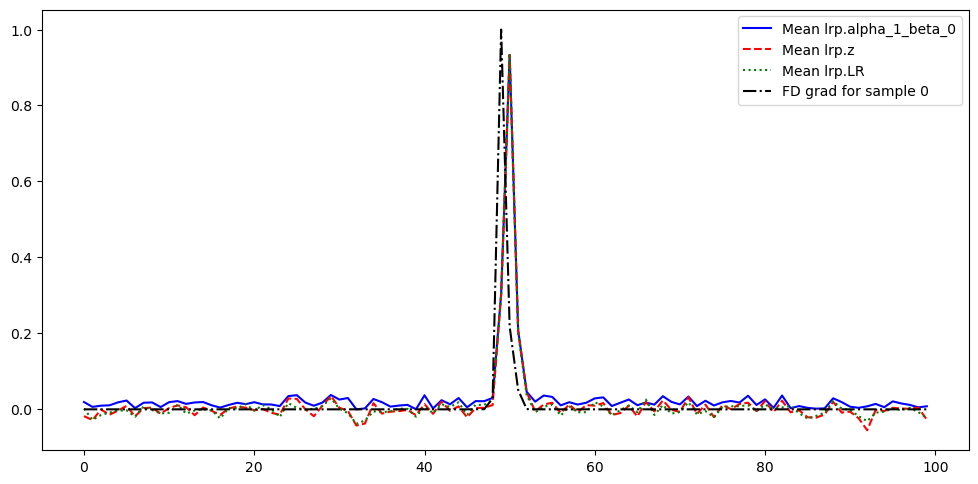

In [7]:
plt.rcParams["figure.figsize"] = (10,5)
fig, ax = plt.subplots(1,1)
fig.tight_layout()

ax.plot(np.mean(a_a1b0, axis = 0)[50:150], 'b', label = 'Mean lrp.alpha_1_beta_0')
ax.plot(np.mean(a_z, axis = 0)[50:150], 'r--', label = 'Mean lrp.z')
ax.plot(np.mean(a_LR, axis = 0)[50:150], 'g:', label = 'Mean lrp.LR')
ax.plot(grad_0[50:150], 'k-.', label = 'FD grad for sample 0')
ax.legend()

In [ ]:
normalizeDict = {'bool_':True, 'kind': 'MaxAbs'}
kwargs = {'y_ref': 0.001}
X = XAIR(best_model, 'lrp.alpha_1_beta_0', 'letzgus', M_samples[:2], normalizeDict, **kwargs)
X.check_sample(M_samples[0]), X.check_sample(M_samples[1])

In [ ]:
%matplotlib inline
a, stats  = X.quick_analyze()
plt.plot(a[0])
plt.plot(a[1])

In [ ]:
y_ref = 0.001
best_model = K.loadBestModel()
normalizeDict = {'bool_':True, 'kind': 'MaxAbs'}
kwargs = {'y_ref': y_ref}
X = XAIR(best_model, 'lrp.z', 'classic', M_samples[:10], normalizeDict, **kwargs)
X.check_sample(M_samples[0]), X.check_sample(M_samples[10])

In [ ]:
a, stats  = X.quick_analyze()
plt.plot(a[0])
plt.plot(a[1])

In [ ]:
L = TrainLR(M_samples, H_samples, y_ref = y_ref, fit_intercept = False)
regr = L.quickTrain()

XL = XLR(regr, M_samples)
a_LR, stats_LR = XL.quick_analyze()

plt.plot(a_LR[0])
plt.plot(a_LR[1])

In [ ]:
y_ref = 0.0004
best_model = K.loadBestModel()
normalizeDict = {'bool_':True, 'kind': 'MaxAbs'}
kwargs = {'y_ref': y_ref}
X = XAIR(best_model, 'lrp.z', 'classic', M_samples[:10], normalizeDict, **kwargs)
X.check_sample(M_samples[0]), X.check_sample(M_samples[10])

In [ ]:
a, stats  = X.quick_analyze()
plt.plot(a[0])
plt.plot(a[1])

In [ ]:
L = TrainLR(M_samples, H_samples, y_ref = y_ref, fit_intercept = False)
regr = L.quickTrain()

XL = XLR(regr, M_samples)
a_LR, stats_LR = XL.quick_analyze()

plt.plot(a_LR[0])
plt.plot(a_LR[1])

In [ ]:
### Try one model with non-zero last layer bias

Layers = [{'size': nx+1, 'activation': None    , 'use_bias': None},
          {'size': 10 , 'activation': 'relu'  , 'use_bias': True},
          {'size': 1  , 'activation': 'linear', 'use_bias': True}]
Losses = [{'kind': 'mse', 'weight': 1.0}]

K = TrainFullyConnectedNN(M_samples, H_samples, 
                    Layers, Losses,
                    'adam', ['mae'], 
                    10, 1000, 0.2, 
                    'model', os.path.abspath(''))

best_model = K.quickTrain()

In [ ]:
y_ref = 0.0004
best_model = K.loadBestModel()
normalizeDict = {'bool_':True, 'kind': 'MaxAbs'}
kwargs = {'y_ref': y_ref}
X = XAIR(best_model, 'lrp.z', 'classic', M_samples[:10], normalizeDict, **kwargs)
X.check_sample(M_samples[0]), X.check_sample(M_samples[10])

In [ ]:
a, stats  = X.quick_analyze()
plt.plot(a[0])
plt.plot(a[1])

In [ ]:
L = TrainLR(M_samples, H_samples, y_ref = y_ref, fit_intercept = False)
regr = L.quickTrain()

XL = XLR(regr, M_samples)
a_LR, stats_LR = XL.quick_analyze()

plt.plot(a_LR[0])
plt.plot(a_LR[1])

In [ ]:
y_ref = 0.0
best_model = K.loadBestModel()
normalizeDict = {'bool_':True, 'kind': 'MaxAbs'}
kwargs = {'y_ref': y_ref}
X = XAIR(best_model, 'lrp.alpha_1_beta_0', 'classic', M_samples, normalizeDict, **kwargs)
a_a1b0, _  = X.quick_analyze()
plt.plot(np.mean(a_a1b0, axis = 0))

In [ ]:
y_ref = 0.0
best_model = K.loadBestModel()
normalizeDict = {'bool_':True, 'kind': 'MaxAbs'}
kwargs = {'y_ref': y_ref}
X = XAIR(best_model, 'lrp.z', 'classic', M_samples, normalizeDict, **kwargs)
a_z, _  = X.quick_analyze()
plt.plot(np.mean(a_z, axis = 0))